# Other NUTS Samplers

In this notebook we show how to fit a CLV model with other NUTS samplers.

```{note}
You need to install these packages in your Python environment.
```

```{tip}
You can pass the exact same `nuts_sampler` argument to the MMM models. 
```

For the purpose of illustration, we will use the same data and model as in the other CLV notebooks.


In [1]:
import arviz as az
import matplotlib.pyplot as plt
from lifetimes.datasets import load_cdnow_summary

from pymc_marketing import clv

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = (
    load_cdnow_summary(index_col=[0])
    .reset_index()
    .rename(columns={"ID": "customer_id"})
)

We can pass the keyword argument `nuts_sampler` to the `fit` method of the `CLV` model to specify the NUTS sampler to use. In addition, we can pass additional keyword arguments which will be passed to the `pymc.sample` method via themodel builder layer.  For example, we can use the `numpyro` sampler as:

In [3]:
model = clv.BetaGeoModel(data=df)
idata_numpyro = model.fit(
    draws=2_000,
    target_accept=0.9,
    chains=5,
    nuts_sampler="numpyro",
    random_seed=42,
)

Compiling...
Compilation time = 0:00:01.462737
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time = 0:00:50.987953
Transforming variables...
Transformation time = 0:00:00.246945


Similarly, we can use the `blackjax` sampler as:

In [4]:
idata_blackjax = model.fit(
    draws=2_000,
    target_accept=0.9,
    chains=5,
    nuts_sampler="blackjax",
    nuts_sampler_kwargs={"chain_method": "parallel"},
    progressbar=False,
    random_seed=42,
)

Compiling...
Compilation time = 0:00:01.382662
Sampling...
Sampling time = 0:00:55.230822
Transforming variables...
Transformation time = 0:00:00.122217


The results from both samplers are almost identical:

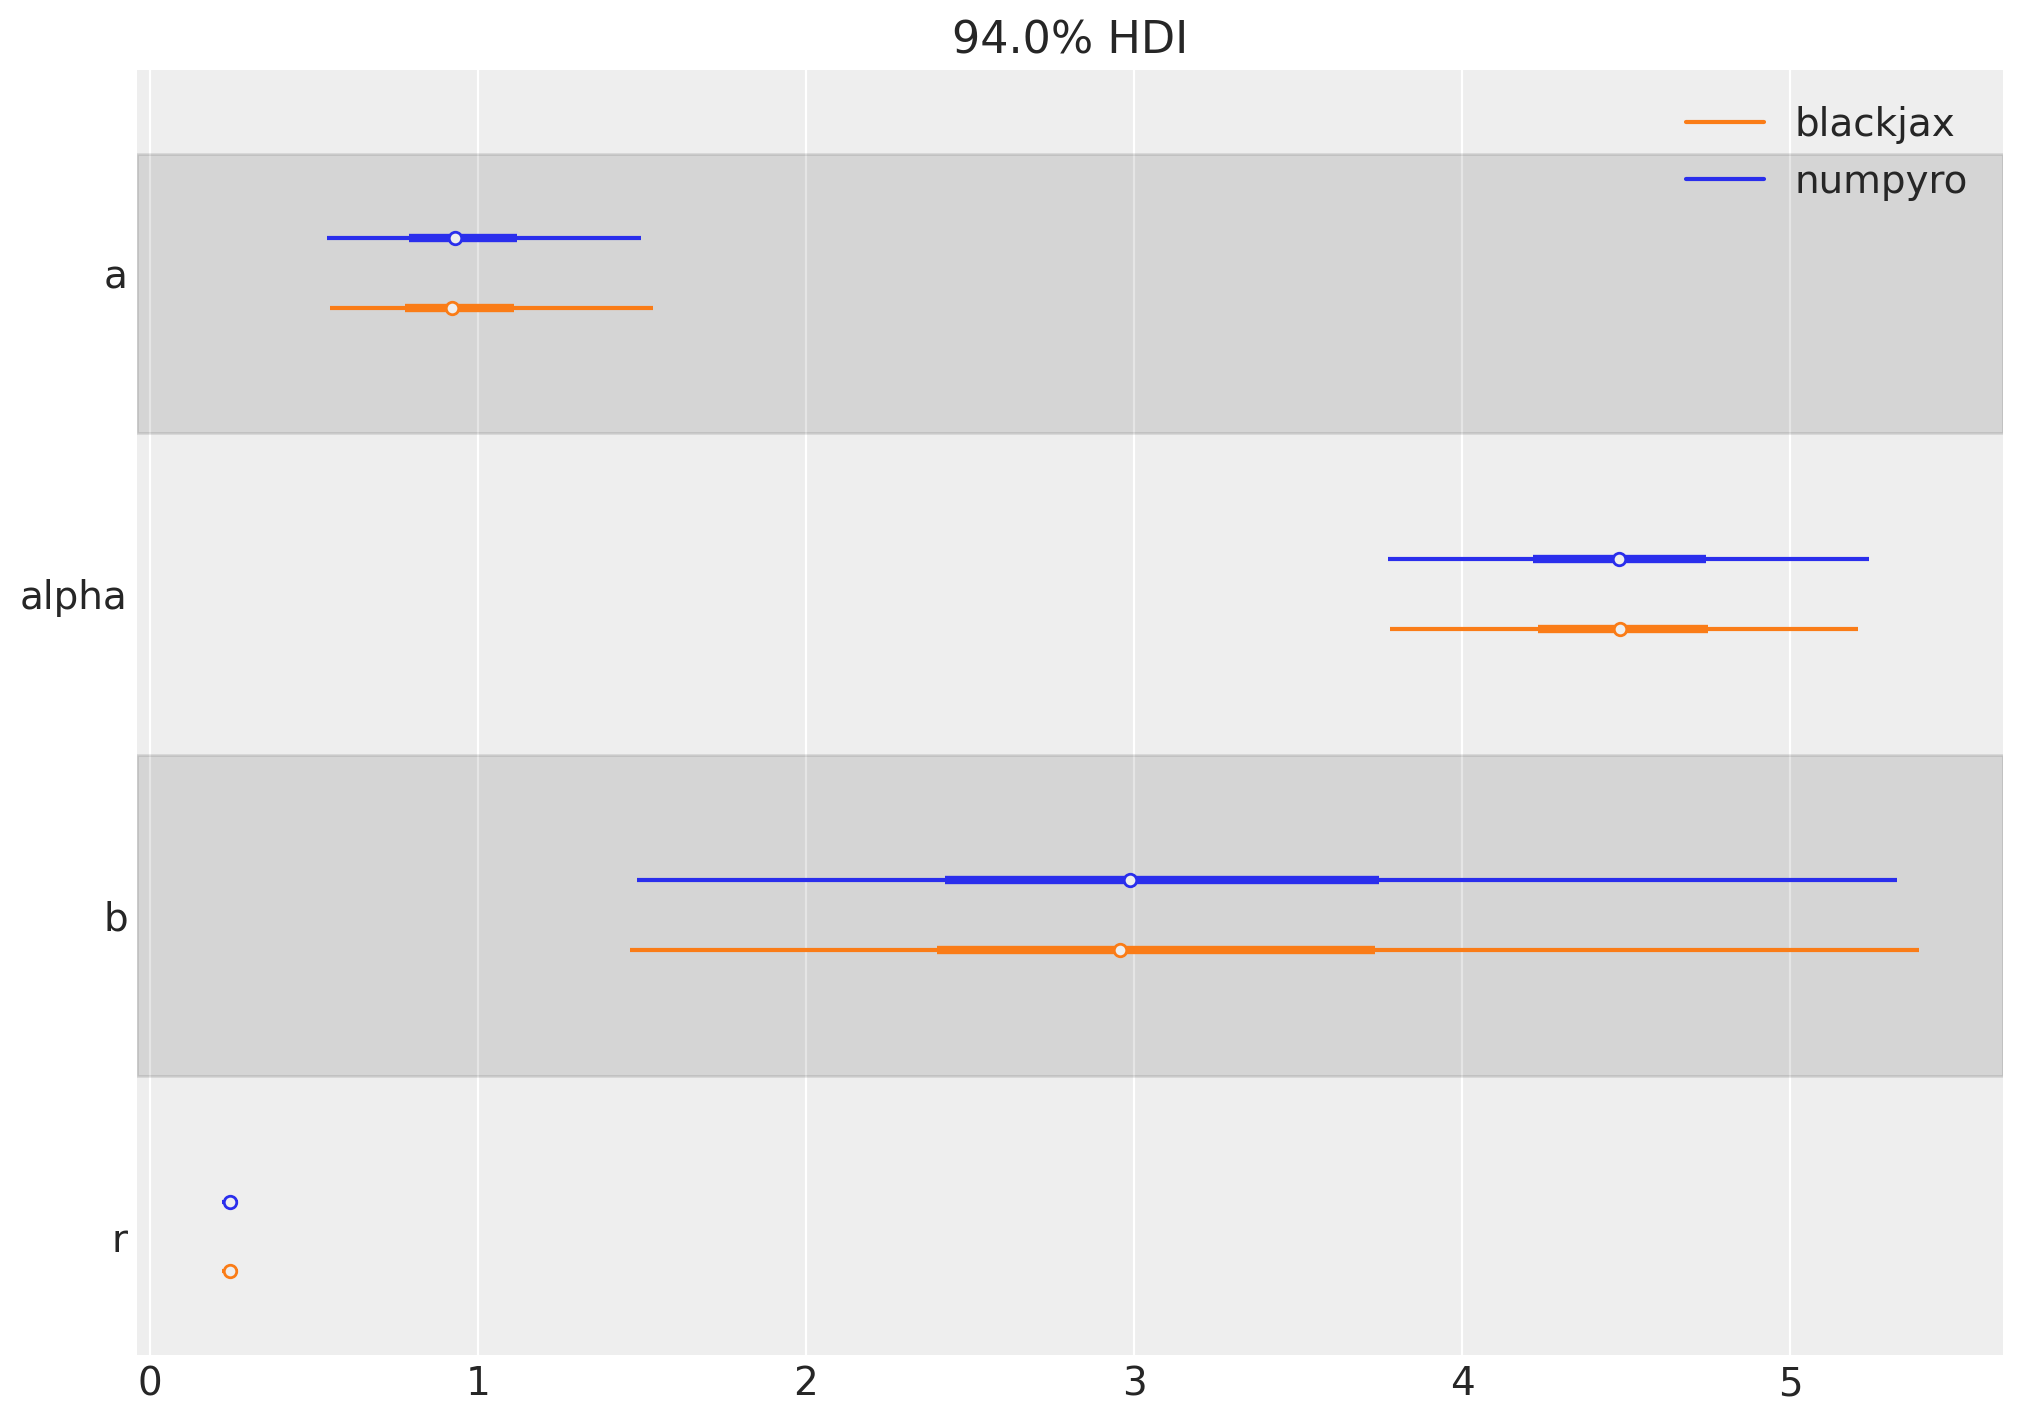

In [5]:
az.plot_forest(
    [idata_numpyro, idata_blackjax],
    model_names=["numpyro", "blackjax"],
    combined=True,
    figsize=(10, 7),
);

In [6]:
%load_ext watermark
%watermark -n -u -v -iv -w -p blackjax,numpyro,pymc

Last updated: Fri Mar 08 2024

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.20.0

blackjax: 0.0.0
numpyro : 0.14.0
pymc    : 5.10.4

matplotlib    : 3.7.1
pymc_marketing: 0.4.0
arviz         : 0.15.1

Watermark: 2.4.3

